In [1]:
# Imports
import os
import glob
import random
import itertools
import numpy as np
import pandas as pd
import tifffile as tf
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score, confusion_matrix, cohen_kappa_score, precision_score,
    recall_score, f1_score, make_scorer
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tqdm import tqdm


In [2]:
# Constants
CLASS_NAMES = [
    "OpenWater",
    "Leads withWater",
    "Brash/Pancake Ice",
    "Thin Ice",
    "Thick Ice-Flat",
    "Thick Ice-Ridged"
]

N_CLASSES = len(CLASS_NAMES)

PATCHES_FOLDER = "Patches32x32\\32"
IMG_SHAPE = (32, 32)
CHANNEL_INDEX = 0  # HH is the first channel (index 0), but we can also take HV (index 1)
ORIENTATIONS  = [0, 45, 90, 135]
FEATURE_NAMES = ['energy', 'contrast', 'correlation', 'homogeneity', 'entropy', 'dissimilarity']
TEST_SIZE_PERCENT = 0.2
RANDOM_STATE = 42

# Data Preparation

In [3]:
def load_and_extract_patches(channel_index):
    patches = []
    labels = []
    
    for class_index in range(len(CLASS_NAMES)):
        class_dir = os.path.join(PATCHES_FOLDER, str(class_index))
        patch_files = glob.glob(os.path.join(class_dir, '*')) 

        for filename in patch_files:
                try:
                    patch = tf.imread(filename)
                    
                    # Select all rows, all columns, and the specified channel index
                    patch = patch[..., channel_index]
                    
                    patch = patch.astype(np.float64) 
                    
                    patches.append(patch)
                    labels.append(class_index)
                    print(f"Successfully loaded and extracted HH from: {filename} (Shape: {patch.shape})")

                except Exception as e:
                    print(f"Error reading {filename}: {e}")

    return patches, labels

patches, labels = load_and_extract_patches(CHANNEL_INDEX)

print(f"\nTotal patches loaded: {len(patches)}")

Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_0041236c-d936-4557-8479-023c94c89200.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_0048bc59-a637-47c1-9a0e-7abdc0557801.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_0065b39d-ffc7-42b5-a6c6-0a8e7fdbb10b.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_007a7de8-cd3f-49a9-8cb7-7cd3a358e2de.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_007d2790-cff8-4347-b22a-a0f3b2c36f23.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_009628df-3784-46af-b10f-99cfee5051f1.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_00d565fc-bb3f-4da0-878c-87dc928b10bd.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_010266cc-6b5b-4eef-9

Text(0.5, 1.0, 'Example Data - Sea Ice Patch')

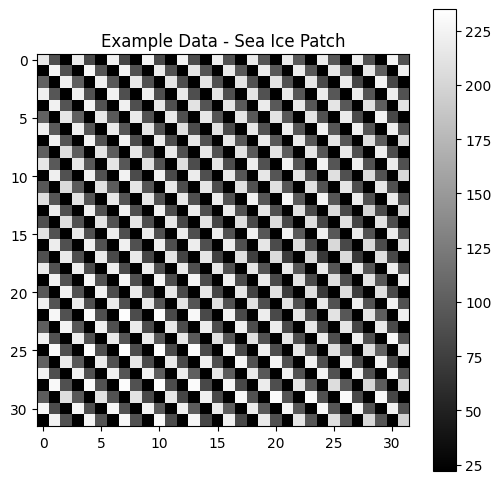

In [91]:
# Plot an example patch
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(patches[0], cmap='gray')
plt.colorbar(img, ax=ax, orientation='vertical')
ax.set_title("Example Data - Sea Ice Patch")

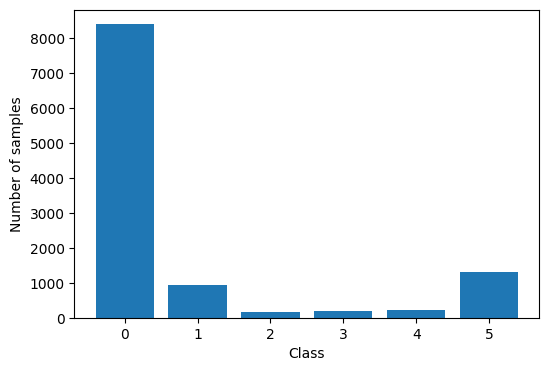

In [5]:
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.show()

In [6]:
MAJORITY_LABEL = 0
TARGET_SIZE = 1300

# 
def balance_dataset_combined(X_data, y_labels, majority_label, target_size):
    """
    Downsamples the majority class and oversamples all minority classes 
    to a common target size.
    """    
    data = pd.DataFrame(X_data)
    data['label'] = y_labels
    
    classes = data['label'].unique()
    
    balanced_data_list = []
        
    # Resample each class
    for current_label in classes:
        
        data_class = data[data.label == current_label]
        n_samples_current = len(data_class)
            
        if n_samples_current > target_size:
            # --- DOWNSAMPLING (For Class 0) ---
            resampled_class = resample(
                data_class,
                replace=False,           
                n_samples=target_size,   
                random_state=RANDOM_STATE
            )
            
        elif n_samples_current < target_size:
            # --- OVERSAMPLING ---
            # not using data augmentation here, just simple resampling with replacement
            # because we are working with feature matrix, not images
            resampled_class = resample(
                data_class,
                replace=True,            
                n_samples=target_size,   
                random_state=RANDOM_STATE
            )

        else:
            resampled_class = data_class

        balanced_data_list.append(resampled_class)
    
    data_balanced = pd.concat(balanced_data_list)
    data_balanced = data_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    
    X_balanced = data_balanced.drop('label', axis=1).values
    y_balanced = data_balanced['label'].values
    
    
    return X_balanced, y_balanced

counts_dict = dict(zip(unique, counts))

N_TOTAL = sum(counts_dict.values())

y_labels = np.zeros(N_TOTAL, dtype=int)

start = 0
for label, cnt in counts_dict.items():
    y_labels[start:start + cnt] = np.full(cnt, label, dtype=int)
    start += cnt


# Method Implementation

In [7]:
def quantize_image(patch: np.ndarray, n_levels: int) -> np.ndarray:
    """Applies uniform quantization locally to a single patch."""
    min_val = patch.min()
    max_val = patch.max()
    if max_val == min_val:
        return np.full(patch.shape, 0, dtype=np.uint8) 

    scaled_patch = ((patch - min_val) / (max_val - min_val)) * n_levels
    quantized_patch = np.clip(scaled_patch, 0, n_levels - 1).astype(np.uint8)
    return quantized_patch


In [8]:
def calculate_mdmo_features(patch: np.ndarray, n_g: int, d_max: int) -> np.ndarray:
    """
    Calculates the 8-feature MDMO vector for given N_G and max displacement.
    """
    displacements = np.arange(1, d_max + 1)
    # Quantize the patch
    quantized_patch = quantize_image(patch, n_g)
    
    # Check for minimum processing requirements (e.g., d=32 needs at least 33x33)
    if min(quantized_patch.shape) < d_max + 1:
        return np.full(len(FEATURE_NAMES), np.nan) 
        
    total_feature_sums = np.zeros(len(FEATURE_NAMES))
    
    # Looping through Mean Displacement
    for d in displacements:
        glcm = graycomatrix(
            quantized_patch, distances=(d,), angles=ORIENTATIONS, 
            levels=n_g, symmetric=True, normed=True
        )
        mean_orientation_features = []
        
        # Mean Orientation (Averaging over theta)
        for feature_name in FEATURE_NAMES:
            # graycoprops returns an array of shape (1, 4) for this feature across the 4 angles
            props = graycoprops(glcm, feature_name)[0]

            # Perform the Mean Orientation averaging (np.mean on the 4 angle values)
            mean_orientation_features.append(np.mean(props))
        
        total_feature_sums += np.array(mean_orientation_features)

    # Average over all displacement values (Mean Displacement)
    mdmo_feature_matrix = total_feature_sums / len(displacements)

    return mdmo_feature_matrix

# Baseline

In [9]:
quantization_schema = 64
displacement = 16

mdmo_data = []

print(f"Starting MDMO feature calculation for {len(patches)} patches...")
for i, patch in enumerate(patches):
    mdmo_vector = calculate_mdmo_features(patch, quantization_schema, displacement)
    if not np.any(np.isnan(mdmo_vector)):
        mdmo_data.append(mdmo_vector)

mdmo_feature_matrix = np.vstack(mdmo_data)

print(f"Shape: {mdmo_feature_matrix.shape}")

glcm_df = pd.DataFrame(mdmo_feature_matrix, columns = FEATURE_NAMES)
glcm_df.head(10)

Starting MDMO feature calculation for 11200 patches...
Shape: (11200, 6)


,energy,contrast,correlation,homogeneity,entropy,dissimilarity
0,0.209216,1153.323591,0.015889,0.205378,4.136223,25.888560
1,0.203453,1093.047773,0.015728,0.197946,4.221070,25.496453
2,0.193251,1069.417478,0.015716,0.183238,4.489047,24.796776
3,0.203023,1105.436687,0.015312,0.196731,4.272212,25.658170
4,0.185665,976.657277,0.015781,0.172595,4.756477,24.434917
5,0.178583,154.363432,0.085437,0.201679,5.080059,9.095891
6,0.177648,879.447715,0.015403,0.163287,4.978743,23.091309
7,0.166375,540.000701,0.013853,0.180056,5.291648,17.344059
8,0.181418,816.984690,0.015778,0.204775,4.882365,20.526263
9,0.207062,1128.318234,0.016190,0.202371,4.202149,25.839297


In [ ]:
X_balanced, y_balanced = balance_dataset_combined(
    mdmo_feature_matrix,
    labels,
    MAJORITY_LABEL, 
    TARGET_SIZE
)


Test Set Classification Accuracy: 0.4776
Cohen's Kappa: 0.3731


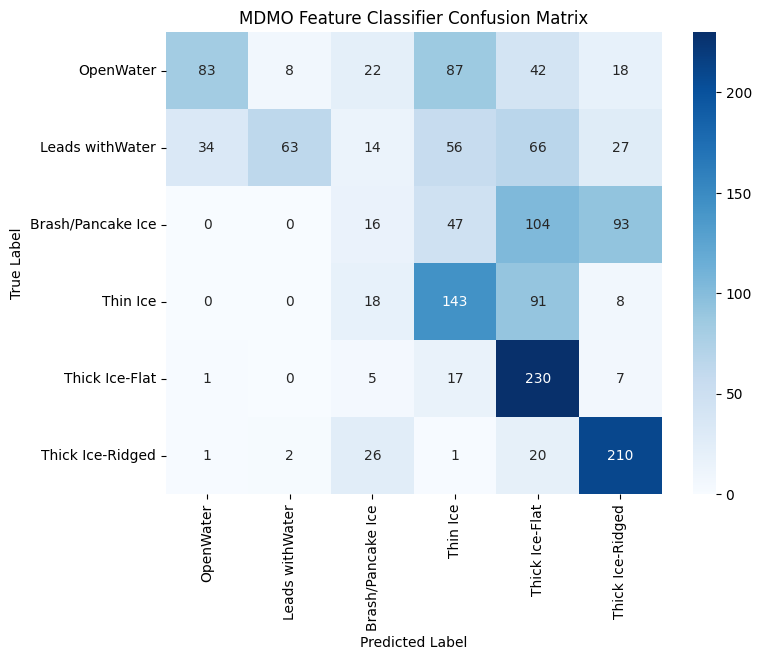

In [11]:
# In the paper they used 50/50 train-test split and Gaussian Naive Bayes classifier
# We are going to try different splits (maybe be classifiers as well)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=TEST_SIZE_PERCENT,
    random_state=RANDOM_STATE, stratify=y_balanced
)

# used Gaussian Naive Bayes classifier as in the paper
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred) # they used KHAT statistics (an estimate of KAPPA)
cm = confusion_matrix(y_test, y_test_pred)

print(f"Test Set Classification Accuracy: {test_accuracy:.4f}")
print(f"Cohen's Kappa: {test_kappa:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MDMO Feature Classifier Confusion Matrix')
plt.show()

# Test Set Classification Accuracy: 0.4776
# Cohen's Kappa: 0.3731

# Test Set Classification Accuracy: 0.4430
# Cohen's Kappa: 0.3314

# Grid Search

## Level quantization, d max

In [ ]:
def glcm_mdmo_grid_search(patches, labels, ng_levels, max_dists):
    best_kappa = -1.0
    best_params = {}
    results = []
    
    # Generate all combinations of parameters
    param_combinations = list(itertools.product(ng_levels, max_dists))
    print(f"Starting Grid Search over {len(param_combinations)} combinations...")
    

    for q_level, d_max  in tqdm(param_combinations, desc="Grid Search Progress"):
                
        displacements = np.arange(1, d_max  + 1)
        mdmo_vectors = []
        valid_labels = []

        for patch, label in zip(patches, labels):            
            quantized_patch = quantize_image(patch, q_level)
            
            # Ensures patch is large enough for the current displacement
            # Perhaps can be omitted
            # Skip if patch is too small for d_max
            if min(quantized_patch.shape) < d_max + 1:
                continue

            feature_sum = np.zeros(len(FEATURE_NAMES))

            # for each displacement, compute GLCM and extract features
            for d in displacements:
                glcm = graycomatrix(
                    quantized_patch, distances=(d,), angles=ORIENTATIONS, 
                    levels=q_level, symmetric=True, normed=True
                )

                # average features across orientations
                for i, feat in enumerate(FEATURE_NAMES):
                    feature_sum[i] += np.mean(graycoprops(glcm, feat)[0])

            # The MDMO vector is the mean of all directional (orientation) and distance-based features.
            mdmo_vector = feature_sum / len(displacements)
            valid_labels.append(label)

            # Skip patches that were too small or resulted in NaNs
            if np.any(np.isnan(mdmo_vector)): continue
            mdmo_vectors.append(mdmo_vector)

        if not mdmo_vectors:
            print(f"Skipping q={q_level}, d_max={d_max} (No valid patches).")
            continue

        X_imbalanced = np.vstack(mdmo_vectors)
        y_imbalanced = np.array(valid_labels)

        # X, y = balance_dataset_combined_synthetic(X_imbalanced, y_imbalanced, MAJORITY_LABEL, TARGET_SIZE)
        X, y = balance_dataset_combined(X_imbalanced, y_imbalanced, MAJORITY_LABEL, TARGET_SIZE)
        
        # CLASSIFICATION AND SCORING
        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=TEST_SIZE_PERCENT,
            random_state=RANDOM_STATE, stratify=y
        )

        # Train and Predict
        classifier = GaussianNB()
        classifier.fit(X_train, y_train)
        y_test_pred = classifier.predict(X_test)
        
        # Calculate Score
        kappa = cohen_kappa_score(y_test, y_test_pred)
        accuracy = accuracy_score(y_test, y_test_pred)
        
        # Store Result
        results.append({
            'QUANTIZATION_LEVEL': q_level, 
            'D_MAX': d_max, 
            'Kappa': kappa,
            'Accuracy': accuracy
        })
        
        # Update Best Parameters
        if kappa > best_kappa:
            best_kappa = kappa
            best_params = {'QUANTIZATION_LEVEL': q_level, 'D_MAX': d_max}
            
    return results, best_params, best_kappa

In [ ]:
quantization_schemes = [16, 32, 64, 128, 256] # Values from the paper
max_displacements = [8, 16, 24] # Range of max d to test (adjust based on patch size)

results, best_params, best_kappa = glcm_mdmo_grid_search(patches, labels, quantization_schemes, max_displacements)

--- Grid Search Results ---

Optimal Parameters: quantization schema=16, d max=24

Best Kappa Score Achieved: 0.3302

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>QUANTIZATION_LEVEL</th>
      <th>D_MAX</th>
      <th>Kappa</th>
      <th>Accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>16</td>
      <td>8</td>
      <td>0.310220</td>
      <td>0.588393</td>
    </tr>
    <tr>
      <th>1</th>
      <td>16</td>
      <td>16</td>
      <td>0.314348</td>
      <td>0.595982</td>
    </tr>
    <tr>
      <th>2</th>
      <td>16</td>
      <td>24</td>
      <td>0.330170</td>
      <td>0.615179</td>
    </tr>
    <tr>
      <th>3</th>
      <td>32</td>
      <td>8</td>
      <td>0.290321</td>
      <td>0.546429</td>
    </tr>
    <tr>
      <th>4</th>
      <td>32</td>
      <td>16</td>
      <td>0.283886</td>
      <td>0.543304</td>
    </tr>
    <tr>
      <th>5</th>
      <td>32</td>
      <td>24</td>
      <td>0.292898</td>
      <td>0.557143</td>
    </tr>
    <tr>
      <th>6</th>
      <td>64</td>
      <td>8</td>
      <td>0.257688</td>
      <td>0.486161</td>
    </tr>
    <tr>
      <th>7</th>
      <td>64</td>
      <td>16</td>
      <td>0.243645</td>
      <td>0.475893</td>
    </tr>
    <tr>
      <th>8</th>
      <td>64</td>
      <td>24</td>
      <td>0.255429</td>
      <td>0.491518</td>
    </tr>
    <tr>
      <th>9</th>
      <td>128</td>
      <td>8</td>
      <td>0.236803</td>
      <td>0.453125</td>
    </tr>
    <tr>
      <th>10</th>
      <td>128</td>
      <td>16</td>
      <td>0.223035</td>
      <td>0.445089</td>
    </tr>
    <tr>
      <th>11</th>
      <td>128</td>
      <td>24</td>
      <td>0.226880</td>
      <td>0.450446</td>
    </tr>
    <tr>
      <th>12</th>
      <td>256</td>
      <td>8</td>
      <td>0.222965</td>
      <td>0.449107</td>
    </tr>
    <tr>
      <th>13</th>
      <td>256</td>
      <td>16</td>
      <td>0.214133</td>
      <td>0.447768</td>
    </tr>
    <tr>
      <th>14</th>
      <td>256</td>
      <td>24</td>
      <td>0.215464</td>
      <td>0.449554</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
quantization_schemes = [4, 8, 16]
max_displacements = [4, 8, 16, 24]

results2, best_params2, best_kappa2 = glcm_mdmo_grid_search(patches, labels, quantization_schemes, max_displacements)

print("\n--- Grid Search Results ---")
print(f"Optimal Parameters: quantization schema={best_params2['QUANTIZATION_LEVEL']}, d max={best_params2['D_MAX']}")
print(f"Best Kappa Score Achieved: {best_kappa2:.4f}")

--- Grid Search Results ---

Optimal Parameters: quantization schema=8, d max=24

Best Kappa Score Achieved: 0.3359

In [ ]:
grid_results2 = pd.DataFrame(results2)
grid_results2.sort_values(by=['Kappa', 'Accuracy'], ascending=[False, False])

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>QUANTIZATION_LEVEL</th>
      <th>D_MAX</th>
      <th>Kappa</th>
      <th>Accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>7</th>
      <td>8</td>
      <td>24</td>
      <td>0.335870</td>
      <td>0.640179</td>
    </tr>
    <tr>
      <th>11</th>
      <td>16</td>
      <td>24</td>
      <td>0.330170</td>
      <td>0.615179</td>
    </tr>
    <tr>
      <th>6</th>
      <td>8</td>
      <td>16</td>
      <td>0.325288</td>
      <td>0.627232</td>
    </tr>
    <tr>
      <th>8</th>
      <td>16</td>
      <td>4</td>
      <td>0.319691</td>
      <td>0.598661</td>
    </tr>
    <tr>
      <th>4</th>
      <td>8</td>
      <td>4</td>
      <td>0.315801</td>
      <td>0.616964</td>
    </tr>
    <tr>
      <th>5</th>
      <td>8</td>
      <td>8</td>
      <td>0.315256</td>
      <td>0.616071</td>
    </tr>
    <tr>
      <th>10</th>
      <td>16</td>
      <td>16</td>
      <td>0.314348</td>
      <td>0.595982</td>
    </tr>
    <tr>
      <th>9</th>
      <td>16</td>
      <td>8</td>
      <td>0.310220</td>
      <td>0.588393</td>
    </tr>
    <tr>
      <th>3</th>
      <td>4</td>
      <td>24</td>
      <td>0.226418</td>
      <td>0.539286</td>
    </tr>
    <tr>
      <th>2</th>
      <td>4</td>
      <td>16</td>
      <td>0.219020</td>
      <td>0.523661</td>
    </tr>
    <tr>
      <th>1</th>
      <td>4</td>
      <td>8</td>
      <td>0.193540</td>
      <td>0.474107</td>
    </tr>
    <tr>
      <th>0</th>
      <td>4</td>
      <td>4</td>
      <td>0.192366</td>
      <td>0.477679</td>
    </tr>
  </tbody>
</table>
</div>

## Classifier

In [240]:
def run_multi_classifier_grid_search(patches, labels, quantization_schemes, max_displacements, classifier_grid):
    results = []
    best_overall_kappa = -1.0
    best_overall_result = {}

    kappa_scorer = make_scorer(cohen_kappa_score)
    glcm_params  = list(itertools.product(quantization_schemes, max_displacements))
    
    for n_g, d_max in tqdm(glcm_params , desc="GLCM Parameter Search"):        
        X_features = []
        y_labels = []
        
        for patch, label in zip(patches, labels):
            mdmo_vector = calculate_mdmo_features(patch, n_g, d_max)
            
            if not np.any(np.isnan(mdmo_vector)):
                X_features.append(mdmo_vector)
                y_labels.append(label)

        if not X_features: continue

        X_balanced, y_balanced = balance_dataset_combined(
            X_features,
            y_labels,
            MAJORITY_LABEL, 
            TARGET_SIZE
        )

        X = np.vstack(X_balanced)
        y = np.array(y_balanced)

        if len(np.unique(y)) < 2: continue
        
        # Scaling and Train/Test split
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=TEST_SIZE_PERCENT, random_state=RANDOM_STATE, stratify=y
        )
        
        # Check if any class is missing in test or train set after stratification (can happen with small, highly imbalanced data)
        if len(np.unique(y_train)) < len(np.unique(y)) or len(np.unique(y_test)) < len(np.unique(y)): continue

        # Classifier Grid Search
        for clf_name, config in classifier_grid.items():            
            grid_search = GridSearchCV(
                estimator=config['model'],
                param_grid=config['params'],
                scoring={'accuracy': 'accuracy', 'kappa': kappa_scorer}, 
                refit='kappa', # Select the best model based on Kappa score
                cv=3, 
                verbose=0
            )
            
            grid_search.fit(X_train, y_train)            
            best_clf = grid_search.best_estimator_
            y_test_pred = best_clf.predict(X_test)
            
            kappa = cohen_kappa_score(y_test, y_test_pred)
            accuracy = accuracy_score(y_test, y_test_pred)

            current_result = {
                'Classifier': clf_name,
                'N_G': n_g,
                'D_MAX': d_max,
                'Best_Hyperparams': grid_search.best_params_,
                'Accuracy': accuracy,
                'Kappa': kappa
            }
            results.append(current_result)
            
            # Update best overall result
            if kappa > best_overall_kappa:
                best_overall_kappa = kappa
                best_overall_result = current_result

    return results, best_overall_result

In [241]:
quantization_schemes = [8, 16] 
max_displacements = [16, 24] 

classifier_grid = {
    'GaussianNB': {
        'model': GaussianNB(), 
        'params': [{}]
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
        'params': [
            {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
        ]
    },
    'SVC': {
        'model': SVC(random_state=RANDOM_STATE, class_weight='balanced'),
        'params': [
            {'C': [1, 10], 'kernel': ['rbf'], 'gamma': ['scale']},
        ]
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': [
            {'n_neighbors': [3, 5, 7, 15], 'weights': ['uniform', 'distance']}
        ]
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=RANDOM_STATE, eval_metric='mlogloss'),
        'params': [
            {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.3], 'max_depth': [3, 6]}
        ]
    }
}


In [242]:
results, best_result = run_multi_classifier_grid_search(patches, labels, quantization_schemes, max_displacements, classifier_grid)

GLCM Parameter Search: 100%|██████████| 4/4 [08:46<00:00, 131.51s/it]


In [178]:
pd.DataFrame(results).sort_values(by=['Kappa', 'Accuracy'], ascending=[False, False])

,Classifier,N_G,D_MAX,Best_Hyperparams,Accuracy,Kappa
1,RandomForest,8,16,"{'max_depth': None, 'n_estimators': 50}",0.916026,0.899231
4,XGBoost,8,16,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti...",0.915385,0.898462
6,RandomForest,8,24,"{'max_depth': None, 'n_estimators': 100}",0.912821,0.895385
16,RandomForest,16,24,"{'max_depth': None, 'n_estimators': 100}",0.910897,0.893077
19,XGBoost,16,24,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti...",0.909615,0.891538
9,XGBoost,8,24,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti...",0.908974,0.890769
11,RandomForest,16,16,"{'max_depth': None, 'n_estimators': 100}",0.908333,0.890000
14,XGBoost,16,16,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti...",0.908333,0.890000
3,KNeighbors,8,16,"{'n_neighbors': 3, 'weights': 'distance'}",0.892949,0.871538
8,KNeighbors,8,24,"{'n_neighbors': 3, 'weights': 'distance'}",0.881410,0.857692


In [177]:
best_result

{'Classifier': 'RandomForest',
 'N_G': 8,
 'D_MAX': 16,
 'Best_Hyperparams': {'max_depth': None, 'n_estimators': 50},
 'Accuracy': 0.916025641025641,
 'Kappa': 0.8992307692307693}

In [243]:
print(best_result)
pd.DataFrame(results).sort_values(by=['Kappa', 'Accuracy'], ascending=[False, False])

{'Classifier': 'RandomForest', 'N_G': 8, 'D_MAX': 16, 'Best_Hyperparams': {'max_depth': None, 'n_estimators': 50}, 'Accuracy': 0.916025641025641, 'Kappa': 0.8992307692307693}


,Classifier,N_G,D_MAX,Best_Hyperparams,Accuracy,Kappa
1,RandomForest,8,16,"{'max_depth': None, 'n_estimators': 50}",0.916026,0.899231
4,XGBoost,8,16,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti...",0.915385,0.898462
6,RandomForest,8,24,"{'max_depth': None, 'n_estimators': 100}",0.912821,0.895385
16,RandomForest,16,24,"{'max_depth': None, 'n_estimators': 100}",0.910897,0.893077
19,XGBoost,16,24,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti...",0.909615,0.891538
9,XGBoost,8,24,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti...",0.908974,0.890769
11,RandomForest,16,16,"{'max_depth': None, 'n_estimators': 100}",0.908333,0.890000
14,XGBoost,16,16,"{'learning_rate': 0.3, 'max_depth': 6, 'n_esti...",0.908333,0.890000
3,KNeighbors,8,16,"{'n_neighbors': 3, 'weights': 'distance'}",0.892949,0.871538
8,KNeighbors,8,24,"{'n_neighbors': 3, 'weights': 'distance'}",0.881410,0.857692


# Run the best model

In [12]:
best_quantization_schema = 8
best_displacement = 16

mdmo_data = []

print(f"Starting MDMO feature calculation for {len(patches)} patches...")
for i, patch in enumerate(patches):
    mdmo_vector = calculate_mdmo_features(patch, best_quantization_schema, best_displacement)
    if not np.any(np.isnan(mdmo_vector)):
        mdmo_data.append(mdmo_vector)

best_mdmo_feature_matrix = np.vstack(mdmo_data)

print(f"Shape: {mdmo_feature_matrix.shape}")

# glcm_df_best = pd.DataFrame(mdmo_feature_matrix, columns = FEATURE_NAMES)

Starting MDMO feature calculation for 11200 patches...
Shape: (11200, 6)


In [ ]:
best_X_balanced, best_y_balanced = balance_dataset_combined(best_mdmo_feature_matrix, labels, MAJORITY_LABEL, TARGET_SIZE)

Test Set Classification Accuracy: 0.9160
Test Set Precision: 0.9143
Test Set Recall: 0.9160
Test Set F1 Score: 0.9137
Cohen's Kappa: 0.8992


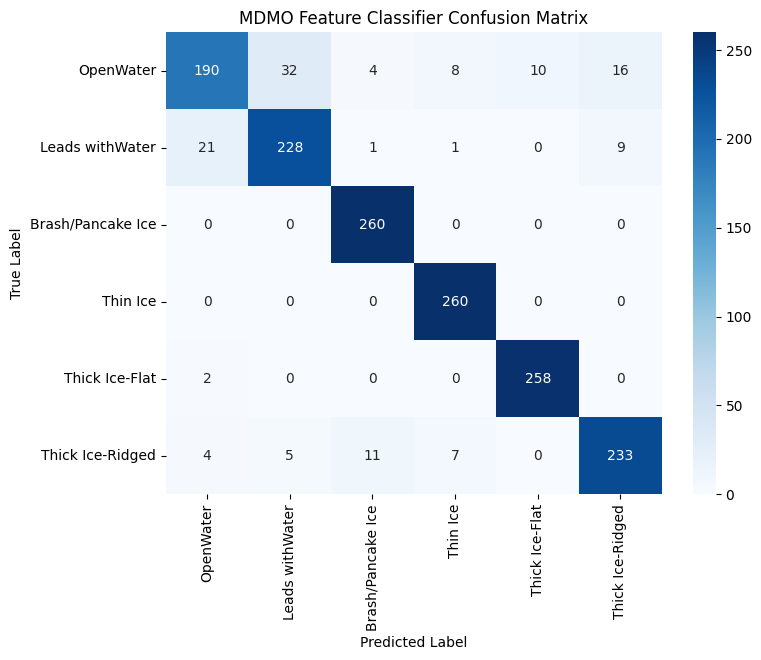

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    best_X_balanced, best_y_balanced, test_size=TEST_SIZE_PERCENT,
    random_state=RANDOM_STATE, stratify=best_y_balanced
)

best_scaler = StandardScaler()
X_train_scaled = best_scaler.fit_transform(X_train)
X_test_scaled = best_scaler.transform(X_test)

best_classifier = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_estimators=50,
    max_depth = None)

best_classifier.fit(X_train_scaled, y_train)
y_test_pred = best_classifier.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_kappa = cohen_kappa_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

print(f"Test Set Classification Accuracy: {test_accuracy:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")
print(f"Cohen's Kappa: {test_kappa:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MDMO Feature Classifier Confusion Matrix')
plt.show()

# Testing on our image

In [15]:
def create_mdmo_texture_map(input_image: np.ndarray, window_size: int, stride: int, n_g, d_max) -> np.ndarray:
    """
    Applies the MDMO feature calculation to a large image using a sliding window.
    """
    H, W = input_image.shape
    
    out_H = (H - window_size) // stride + 1
    out_W = (W - window_size) // stride + 1
    
    # Initialize the output map: (Height, Width, 8 Features)
    texture_map = np.empty((out_H, out_W, len(FEATURE_NAMES)))

    print(f"Input image shape: {H}x{W}. Output map shape: {out_H}x{out_W}x{len(FEATURE_NAMES)}")
    
    # Sliding Window Loop
    for i in tqdm(range(out_H), desc="Generating Texture Map"):
        for j in range(out_W):
            
            r_start = i * stride
            r_end = r_start + window_size
            c_start = j * stride
            c_end = c_start + window_size
            
            # Extract the current patch
            patch = input_image[r_start:r_end, c_start:c_end]
            
            # Calculate the MDMO feature vector for the patch
            mdmo_vector = calculate_mdmo_features(patch, n_g, d_max)
            
            # Store the 8-element vector in the output map
            texture_map[i, j, :] = mdmo_vector

    return texture_map

In [ ]:
WINDOW_SIZE = 32 # Must match the patch size you used in the grid search
STRIDE = 32      # Non-overlapping for fast visualization

def norm_percentile(x, low=2, high=98):
    """Normalizes data to [0, 1] using percentiles to clip outliers."""
    vmin, vmax = np.nanpercentile(x, [low, high])
    return np.clip((x - vmin) / (vmax - vmin), 0, 1)

hh_path = r"measurement/s1a-ew-grd-hh-20150404t055808-20150404t055908-005330-006c0b-001.tiff"
hv_path = r"measurement/s1a-ew-grd-hv-20150404t055808-20150404t055908-005330-006c0b-002.tiff"

with rasterio.open(hh_path) as src:
    hh = src.read(1).astype('float32')
with rasterio.open(hv_path) as src:
    hv = src.read(1).astype('float32')

hh_db = 10 * np.log10(np.where(hh > 0, hh, np.nan))
hv_db = 10 * np.log10(np.where(hv > 0, hv, np.nan))

hh_db_input = np.nan_to_num(hh_db, nan=np.nanmin(hh_db))


In [17]:
mdmo_texture_map = create_mdmo_texture_map(hh_db_input, WINDOW_SIZE, STRIDE, best_quantization_schema, best_displacement)

Input image shape: 9989x10384. Output map shape: 312x324x6


Generating Texture Map: 100%|██████████| 312/312 [09:47<00:00,  1.88s/it]


In [18]:
def generate_classification_map(classifier, scaler, mdmo_texture_map):
    """
    Generates the final classification map by predicting on the texture map.    
    """
    H_map, W_map, N_Features = mdmo_texture_map.shape
    
    # Reshape the texture map for prediction (Samples x Features)
    X_map_flat = mdmo_texture_map.reshape(-1, N_Features)
    
    # normalization
    X_map_processed = scaler.transform(X_map_flat)

    print(f"Predicting classes for {X_map_processed.shape[0]} blocks using {classifier.__class__.__name__}...")
    
    # Predict classes for every block
    predicted_labels_flat = classifier.predict(X_map_processed)
    
    # Reshape the labels back into a 2D map
    classification_map = predicted_labels_flat.reshape(H_map, W_map)
    
    return classification_map

def visualize_upscaled_map(classification_map, original_image, window_size, classifier_name):
    """
    Upscales the classification map to the resolution of the original image 
    and displays it alongside the raw data.
    """
    map_h, map_w = classification_map.shape
    
    # Upscale the classification map (nearest neighbor interpolation/repeat)
    # The output size will be (H_map * window_size) x (W_map * window_size)
    upscaled_map = np.repeat(np.repeat(classification_map, window_size, axis=0), window_size, axis=1)

    
    # colors for visualization corresponding to classes
    # Prepare Colormap
    CLASS_COLORS = {
        0: 'blue',   
        1: 'cyan',     
        2: 'orange',    
        3: 'yellow',  
        4: 'grey',  
        5: 'red'  
    }
    predicted_classes = sorted(np.unique(classification_map))
    cmap = ListedColormap([CLASS_COLORS.get(i, 'gray') for i in predicted_classes])
    bounds = np.array(predicted_classes + [predicted_classes[-1] + 1])
    norm = BoundaryNorm(bounds, cmap.N)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    
    # Original Image
    # We crop the original image to match the size of the upscaled map
    H_orig, W_orig = upscaled_map.shape
    
    axes[0].imshow(original_image[:H_orig, :W_orig])
    axes[0].set_title("Original Sentinel-1 HH (dB)")
    axes[0].axis('off')
    
    # Upscaled Classification Map
    img = axes[1].imshow(upscaled_map, cmap=cmap, norm=norm, interpolation='nearest')
    axes[1].set_title(f"{classifier_name} Classification Map ")
    axes[1].axis('off')

    # Create Legend
    handles = [plt.Rectangle((0,0),1,1, color=CLASS_COLORS.get(i, 'gray')) for i in predicted_classes]
    labels = [f'{CLASS_NAMES[i]}' for i in predicted_classes]
    axes[1].legend(handles, labels, title='Predicted Class', loc='lower left', bbox_to_anchor=(1.05, 0))

    plt.tight_layout()
    plt.show()



Predicting classes for 101088 blocks using RandomForestClassifier...


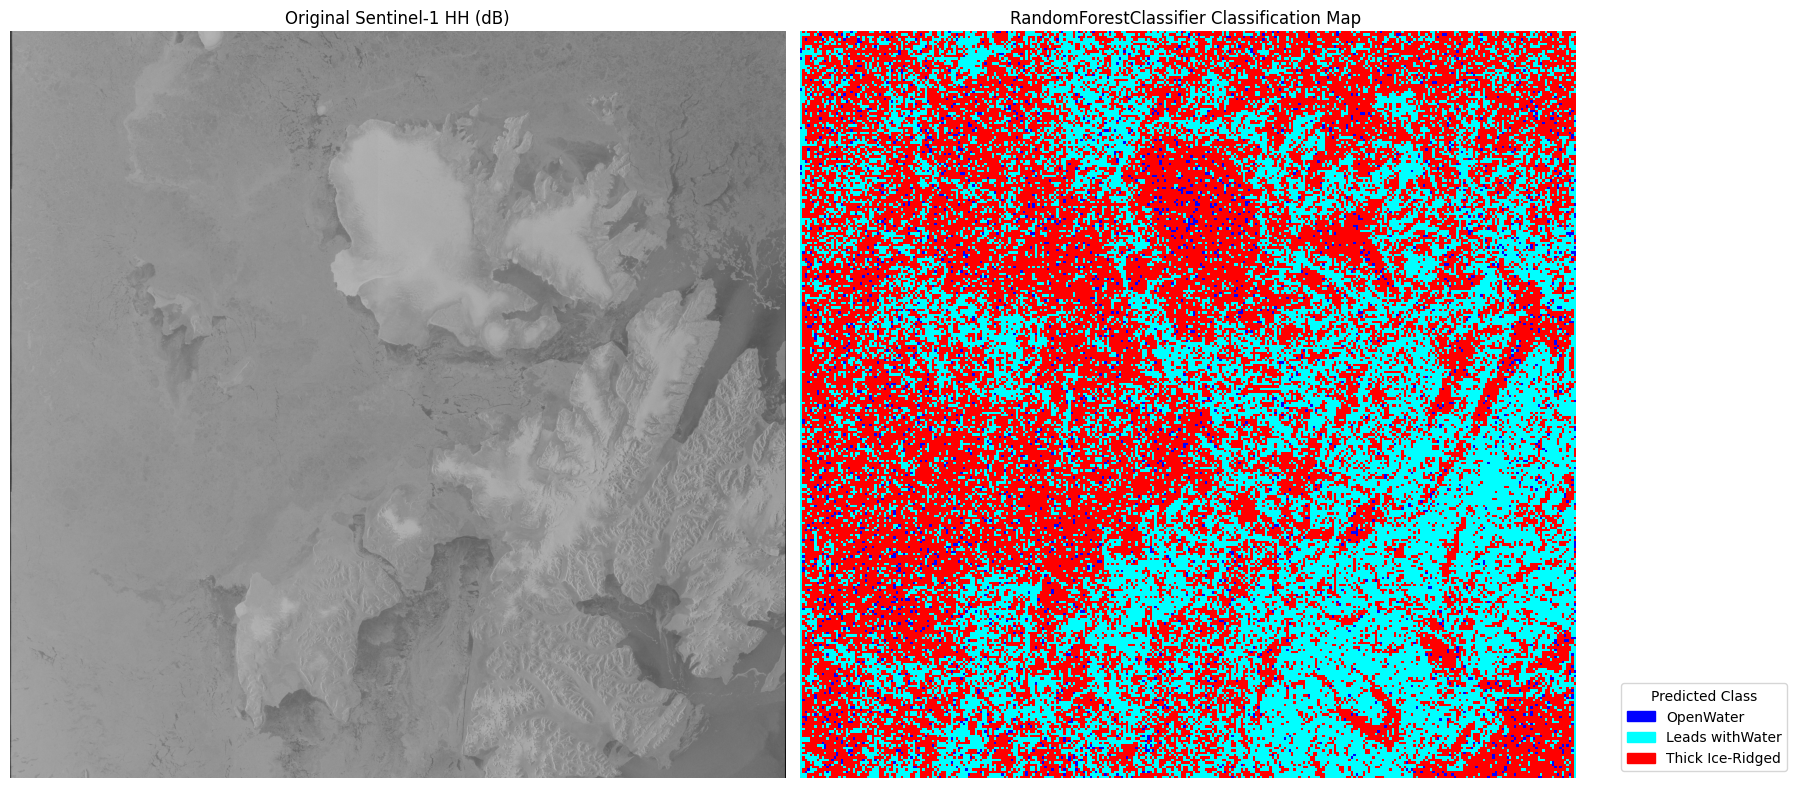

In [223]:
classification_map = generate_classification_map(best_classifier, best_scaler, mdmo_texture_map)
visualize_upscaled_map(classification_map, hh_db_input, WINDOW_SIZE, 'RandomForestClassifier')